In [3]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Finings

1. How has the distribution of fines changed over time?

## How has the distribution of fines changed over time?

In [1]:
# pivot data
gdpr_model_data = (
    fines_long2
    .assign(violated=1, total_fine_euro = lambda x: np.log10(x.total_fine_euro))
    .query('year > 2000')
    .pivot_table(values=['violated'], index=['id', 'year', 'country', 'type', 'total_fine_euro', 'n_articles_violated', 'article_number'])
    .unstack(level=-1, fill_value=0)
)

# sort out indexing
gdpr_model_data.columns = gdpr_model_data.columns.droplevel(0)
gdpr_model_data.columns.name = None

gdpr_model_data.columns = ['A' + str(col) for col in gdpr_model_data.columns]

gdpr_model_data = pd.get_dummies(gdpr_model_data.reset_index())

NameError: name 'fines_long2' is not defined

In [303]:
gdpr_model_data.dtypes.value_counts()

uint8      71
int64      41
float64     1
Int64       1
dtype: int64

In [212]:
fines_dummies = pd.get_dummies(fines_long2, drop_first=True)

In [168]:
known_articles = (
    fines_long
    .sort_values('article_number')
    .dropna(subset='article_number')
)

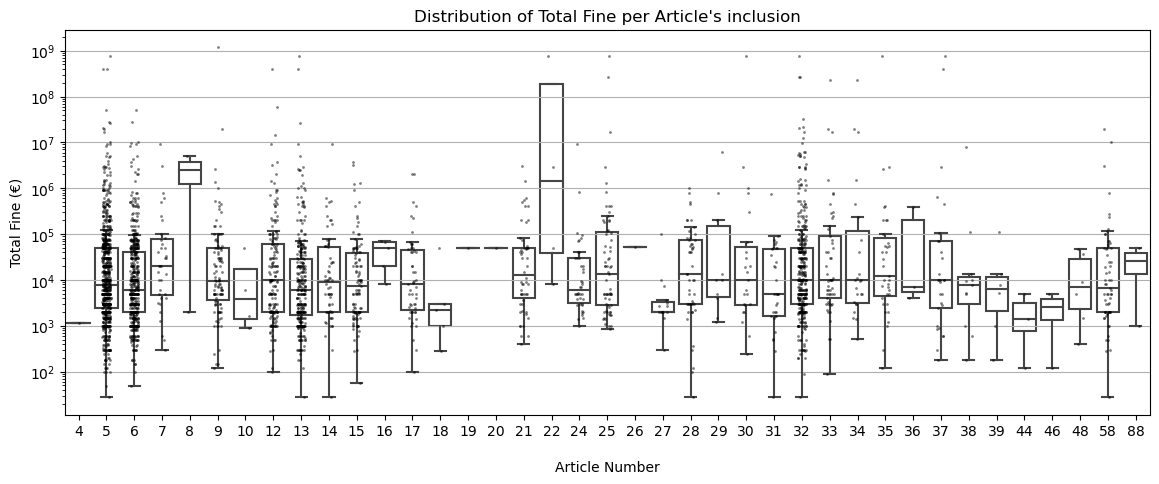

In [169]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.set_yscale("log")

sns.boxplot(
    x='article_number',
    y='total_fine_euro',
    data=known_articles,
    ax=ax,
    showfliers=False,
    boxprops={'facecolor':'white'}
)

sns.stripplot(
    x='article_number',
    y='total_fine_euro',
    data=known_articles,
    color='black',
    jitter=0.15,
    size=2,
    alpha=0.5,
    ax=ax
)

ax.yaxis.grid(True)
ax.set_title(label='', loc='left')
ax.set(xlabel="\nArticle Number", ylabel='Total Fine (€)', title='Distribution of Total Fine per Article\'s inclusion');

In [170]:
MINUMUM_INCIDENCE = 30

overmin_incidence = (
    known_articles
    .loc[known_articles.article_number.isin(known_articles.value_counts('article_number').where(lambda x: x >= MINUMUM_INCIDENCE).dropna().index.to_list())]
)

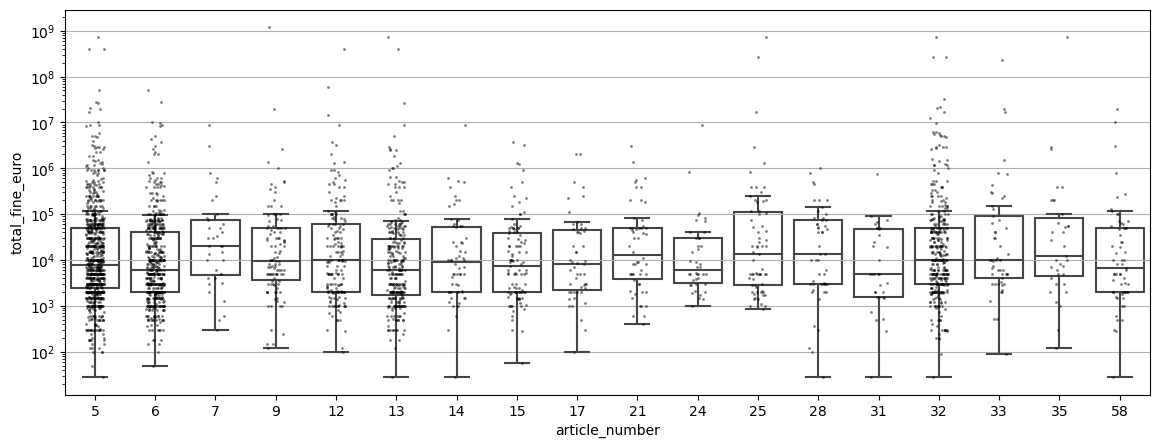

In [171]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.set_yscale("log")

sns.boxplot(
    x='article_number',
    y='total_fine_euro',
    data=overmin_incidence,
    ax=ax,
    showfliers=False,
    boxprops={'facecolor':'white'}
)

sns.stripplot(
    x='article_number',
    y='total_fine_euro',
    data=overmin_incidence,
    color='black',
    jitter=0.15,
    size=2,
    alpha=0.5,
    ax=ax
)

ax.yaxis.grid(True)

## Creating a Dataset for Modelling

In [295]:
# pivot data
gdpr_model_data = (
    overmin_incidence
    .assign(violated=1, year = lambda x: x.date.dt.year, total_fine_euro = lambda x: np.log10(x.total_fine_euro))
    .loc[:, ['id','year', 'country', 'total_fine_euro', 'article_number', 'violated']]
    .query('year > 2000')
    .pivot_table(values=['violated'], index=['id', 'year', 'country', 'total_fine_euro', 'article_number'])
    .unstack(level=-1, fill_value=0)
)

# sort out indexing
gdpr_model_data.columns = gdpr_model_data.columns.droplevel(0)
gdpr_model_data.columns.name = None

gdpr_model_data.columns = ['A' + str(col) for col in gdpr_model_data.columns]

gdpr_model_data = gdpr_model_data.reset_index()

# Regressing Article on Total Fine Price

In [259]:
import statsmodels.api as sm

In [291]:
gdpr_model_data.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
id,1533.0,838.091324,486.112132,1.0,417.0,829.0,1257.0,1700.0
year,1533.0,2021.058708,1.206682,2018.0,2020.0,2021.0,2022.0,2023.0
total_fine_euro,1533.0,4.035449,1.0207,1.447158,3.30103,3.845098,4.653213,9.079181
n_articles_violated,1533.0,2.057404,1.451781,1.0,1.0,2.0,2.0,12.0
A4,1533.0,0.000652,0.02554,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
type_Several,1533.0,0.002609,0.051031,0.0,0.0,0.0,0.0,1.0
type_Unknown,1533.0,0.007175,0.084431,0.0,0.0,0.0,0.0,1.0
type_Various offences,1533.0,0.001305,0.036108,0.0,0.0,0.0,0.0,1.0
type_https://dataprivacy.foxrothschild.com/2019/01/articles/european-union/hessian-dpa-fines-shipping-company-for-missing-data-processing-agreement/,1533.0,0.000652,0.02554,0.0,0.0,0.0,0.0,1.0


In [404]:
# TODO:: include country in regression (just to see)

X = gdpr_model_data.drop(columns=["id", "total_fine_euro", "n_articles_violated"].extend(gdpr_model_data.columns.str.startswith('type').tolist()))
y = gdpr_model_data.total_fine_euro

mod = sm.OLS(y, X.assign(constant=1).astype('float'))
res = mod.fit()

coefs = pd.concat([res.params, res.conf_int()], axis=1)

coefs.columns = ['estimate', 'ci0', 'ci1']

ValueError: Need to specify at least one of 'labels', 'index' or 'columns'

In [ ]:
res.summary()

In [384]:
(
    fines_nozero
    .assign(authority = lambda x: x.authority.str.upper().str.strip())
    .groupby('authority').agg({'price':['median', 'mean', 'sum', 'count']})
    .droplevel(level=0, axis='columns')
    .reset_index()
    .sort_values('sum', ascending=False)
) 

,authority,median,mean,sum,count
18,DATA PROTECTION AUTHORITY OF IRELAND,280000.0,1.140984e+08,2510165800,22
46,NATIONAL COMMISSION FOR DATA PROTECTION (CNPD),2800.0,2.407459e+07,746312300,31
35,FRENCH DATA PROTECTION AUTHORITY (CNIL),400000.0,8.299842e+06,298794300,36
44,ITALIAN DATA PROTECTION AUTHORITY (GARANTE),10000.0,5.957979e+05,144183096,242
41,INFORMATION COMMISSIONER (ICO),1405000.0,5.779446e+06,75132800,13
54,SPANISH DATA PROTECTION AUTHORITY (AEPD),5000.0,7.706978e+04,45625310,592
16,DATA PROTECTION AUTHORITY OF HAMBURG,7555.0,2.772618e+06,33271418,12
36,HELLENIC DATA PROTECTION AUTHORITY (HDPA),15000.0,5.882115e+05,30587000,52
0,AUSTRIAN DATA PROTECTION AUTHORITY (DSB),4800.0,1.507381e+06,19595950,13
27,DATA PROTECTION AUTHORITY OF SWEDEN,54000.0,5.603872e+05,16251230,29


In [380]:
(
    fines_nozero.query('authority ==  "Information Commissioner (ICO)"').sort_values('price', ascending=False)
)

,id,picture,name,price,authority,date,controller,articleViolated,type,source,summary
23,24,https://www.privacyaffairs.com/wp-content/uplo...,United Kingdom,22046000,Information Commissioner (ICO),2020-10-16,British Airways,"Art. 5 (1) f) GDPR, Art. 32 GDPR",Failure to implement sufficient measures to en...,,"Back in July 2019, the ICO notified the Britis..."
22,23,https://www.privacyaffairs.com/wp-content/uplo...,United Kingdom,20450000,Information Commissioner (ICO),2020-10-30,"Marriott International, Inc",Art. 32 GDPR,Failure to implement sufficient measures to en...,https://ico.org.uk/about-the-ico/news-and-even...,In a cyber incident previously notified to the...
1327,1328,https://www.privacyaffairs.com/wp-content/uplo...,United Kingdom,14500000,Information Commissioner (ICO),2023-04-04,TikTok,"Art. 5 (1) a) GDPR, Art. 12 GDPR, Art. 13 GDPR",Failure to comply with data processing principles,,The UK DPA (also known as ICO) has fined TikTo...
1054,1055,https://www.privacyaffairs.com/wp-content/uplo...,United Kingdom,9000000,Information Commissioner (ICO),2022-05-18,Clearview AI Inc.,"Art. 5 (1) a), e) GDPR, Art. 6 GDPR, Art. 9 GD...",Failure to comply with data processing principles,,The UK DPA has fined Clearview AI Inc. with EU...
1287,1288,https://www.privacyaffairs.com/wp-content/uplo...,United Kingdom,5033000,Information Commissioner (ICO),2022-10-19,Interserve Group Limited,"Art. 5 (1) f) GDPR, Art. 32 GDPR",Failure to comply with data processing principles,,The British DPA has fined the construction gro...
509,510,https://www.privacyaffairs.com/wp-content/uplo...,United Kingdom,1405000,Information Commissioner (ICO),2020-11-13,Ticketmaster UK Limited,"Art. 5 (1) f) GDPR, Art. 32 GDPR",Failure to implement sufficient measures to en...,,Ticketmaster UK Limited received a fine of GBP...
853,854,https://www.privacyaffairs.com/wp-content/uplo...,United Kingdom,585000,Information Commissioner (ICO),2021-11-25,Cabinet Office,"Art. 5 (1) f) GDPR, Art. 32 GDPR",Failure to implement sufficient measures to en...,,The UK DPA (also known as ICO) has fined the C...
166,167,https://www.privacyaffairs.com/wp-content/uplo...,United Kingdom,320000,Information Commissioner (ICO),2019-12-17,Doorstep Dispensaree,Art. 32 GDPR,Failure to implement sufficient measures to en...,https://ico.org.uk/media/action-weve-taken/enf...,"The company had stored some 500,000 documents ..."
1677,1678,https://www.privacyaffairs.com/wp-content/uplo...,United Kingdom,91000,Information Commissioner (ICO),2022-06-09,Tavistock & Portmann NHS Foundation Trust,"Art. 5 (1) f) GDPR, Art. 32 GDPR",Failure to comply with data processing principles,,The UK DPA (also known as ICO) has fined the T...
613,614,https://www.privacyaffairs.com/wp-content/uplo...,United Kingdom,29000,Information Commissioner (ICO),2021-07-05,Mermaids,"Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR",Failure to implement sufficient measures to en...,,The ICO has fined the transgender charity Merm...


In [394]:
gdpr_model_data

,id,year,total_fine_euro,n_articles_violated,A4,A5,A6,A7,A8,A9,...,type_Non-compliance with subjects' rights protection safeguards,type_Non-compliance with subjects’ rights protection safeguards,type_Non-compliance with the right of consent,type_Non-cooperation with Data Protection Authority,type_Not known,type_Several,type_Unknown,type_Various offences,type_https://dataprivacy.foxrothschild.com/2019/01/articles/european-union/hessian-dpa-fines-shipping-company-for-missing-data-processing-agreement/,type_nsufficient fulfilment of information obligations
0,1,2019,3.972203,4,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2019,3.397940,2,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2019,4.778151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,2019,3.903090,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,2019,5.176091,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,1695,2022,7.301030,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529,1697,2023,6.716003,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1530,1698,2020,3.301030,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1531,1699,2020,3.397940,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [393]:
X = gdpr_model_data.drop(columns=["id", "total_fine_euro", "country", "year"])
y = gdpr_model_data.total_fine_euro

mod = sm.OLS(y, X.assign(constant=1))
res = mod.fit()

coefs = pd.concat([res.params, res.conf_int()], axis=1)

coefs.columns = ['estimate', 'ci0', 'ci1']

KeyError: "['country'] not found in axis"

In [314]:
coefTable = (
    coefs
    .reset_index(names='coef')
    .assign(
        ci_length = lambda x: x.ci1 - x.estimate,
        hits0     = lambda x: (0 > x.ci0) & (0 < x.ci1)
    )
    .loc[lambda x: x.coef != 'constant', ['coef', 'estimate', 'ci_length', 'hits0']]
)

In [315]:
coefTable.head(2)

,coef,estimate,ci_length,hits0
0,year,-0.067676,0.041803,False
1,n_articles_violated,-0.081531,0.149382,True


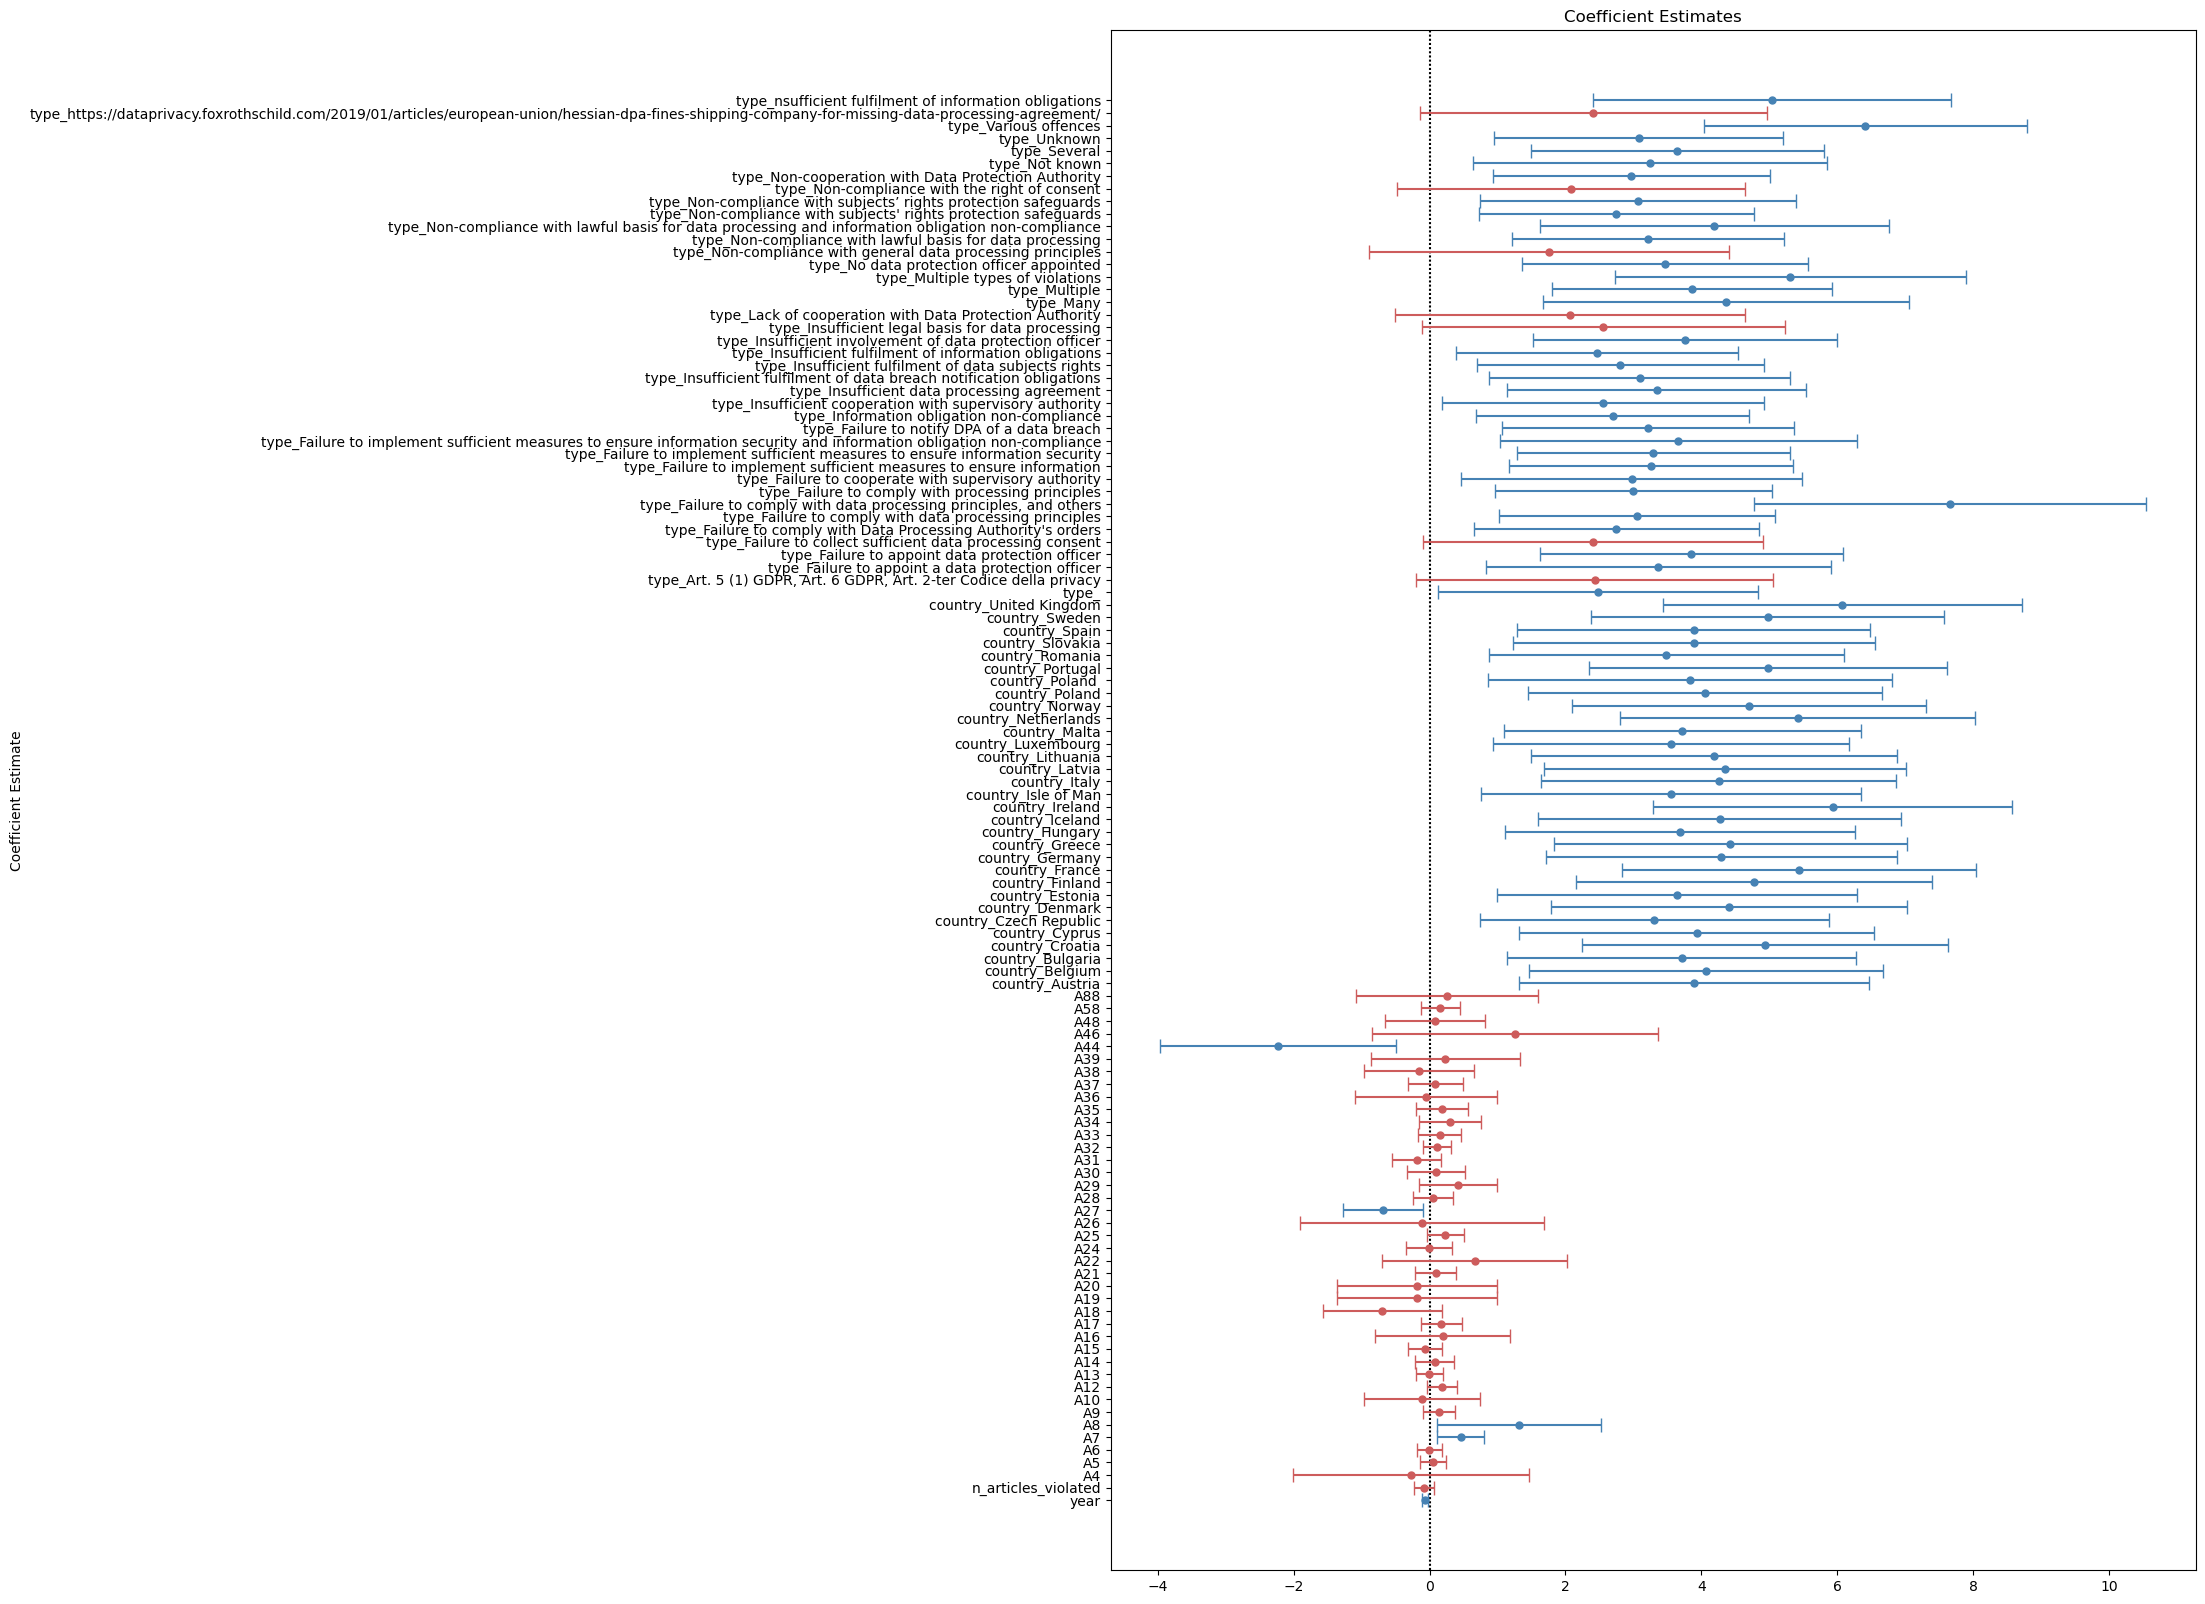

In [397]:
colors = {'True': 'indianred', 'False': 'steelblue'}

fig, ax = plt.subplots(figsize=(14, 20))

ax.axvline(x=0, color="black", linestyle=(0, (1, 1)))
ax.set(xlabel=None, ylabel="Coefficient Estimate", title="Coefficient Estimates", yticks=coefTable.index, yticklabels=coefTable.coef)

for hit_type in np.unique(coefTable.hits0):
    color = colors[str(hit_type)]
    df_subset = coefTable.query(f'hits0 == {hit_type}')
    ax.errorbar(
        df_subset.estimate, df_subset.index, xerr=df_subset.ci_length,
        marker='o', color=color, ls='', ms=5, capsize=5, label=hit_type
    )

plt.show()

In [392]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        total_fine_euro   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     7.586
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           1.63e-82
Time:                        15:59:48   Log-Likelihood:                -1855.0
No. Observations:                1533   AIC:                             3930.
Df Residuals:                    1423   BIC:                             4517.
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================================================================================================
                                                                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
year                                                                                                                                                    -0.0677      0.021     -3.176      0.002      -0.109      -0.026
n_articles_violated                                                                                                                                     -0.0815      0.076     -1.071      0.285      -0.231       0.068
A4                                                                                                                                                      -0.2735      0.887     -0.308      0.758      -2.014       1.467
A5                                                                                                                                                       0.0544      0.096      0.567      0.571      -0.134       0.242
A6                                                                                                                                                      -0.0032      0.095     -0.034      0.973      -0.189       0.183
A7                                                                                                                                                       0.4584      0.175      2.620      0.009       0.115       0.802
A8                                                                                                                                                       1.3108      0.615      2.131      0.033       0.104       2.517
A9                                                                                                                                                       0.1359      0.121      1.121      0.263      -0.102       0.374
A10                                                                                                                                                     -0.1103      0.433     -0.255      0.799      -0.959       0.738
A12                                                                                                                                                      0.1806      0.115      1.576      0.115      -0.044       0.405
A13                                                                                                                                                     -0.0033      0.099     -0.034      0.973      -0.198       0.191
A14                                          

1. Who pays the most?
2. Who pays the most often? 
3. Which articles are the biggest culprits? 

13 is better to violate than 7, 12, 32, or 33. Can't really say about the others.


In [14]:
# pivot data
gdpr_model_data = (
    only_top_n_highest_fines
    .assign(violated=1, year = lambda x: x.date.dt.year, total_fine_euro = lambda x: np.log10(x.total_fine_euro))
    .loc[:, ['id','year', 'country', 'total_fine_euro', 'article_number', 'violated']]
    .query('year > 2000')
    .pivot_table(values=['violated'], index=['id', 'year', 'country', 'total_fine_euro', 'article_number'])
    .unstack(level=-1, fill_value=0)
)

In [15]:
# sort out indexing
gdpr_model_data.columns = gdpr_model_data.columns.droplevel(0)
gdpr_model_data.columns.name = None

gdpr_model_data.columns = ['article_' + str(col) for col in gdpr_model_data.columns]

gdpr_model_data = gdpr_model_data.reset_index()

In [20]:
gdpr_model_data

,id,year,country,total_fine_euro,article_5,article_9,article_12,article_13,article_22,article_25,article_30,article_32,article_35,article_37
0,1,2019,Poland,3.972203,1,0,1,1,0,0,0,0,0,0
1,2,2019,Romania,3.397940,1,0,0,0,0,0,0,0,0,0
2,4,2019,Spain,3.903090,0,0,0,0,0,0,0,1,0,0
3,5,2019,Romania,5.176091,0,0,0,0,0,0,0,1,0,0
4,6,2019,Romania,4.301030,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1694,2022,Cyprus,3.176091,1,1,1,0,0,0,0,0,0,0
1196,1697,2023,France,6.716003,0,0,0,0,0,0,0,1,0,0
1197,1698,2020,Malta,3.301030,1,0,0,0,0,0,0,1,0,0
1198,1699,2020,Malta,3.397940,0,0,0,1,0,0,0,0,0,0


In [40]:
with_controller = (
    only_top_n_highest_fines
    .assign(violated=1, year = lambda x: x.date.dt.year)
    .loc[:, ['id', 'date', 'year', 'country', 'total_fine_euro', 'article_number', 'violated', 'controller']]
    .query('year > 2000')
    .pivot_table(values=['violated'], index=['id','date', 'year', 'country', 'total_fine_euro', 'article_number', 'controller'])
    .unstack(level=-2, fill_value=0)
)

# sort out indexing
with_controller.columns = with_controller.columns.droplevel(0)
with_controller.columns.name = None

with_controller.columns = ['article_' + str(col) for col in with_controller.columns]

with_controller = with_controller.reset_index()

NameError: name 'only_top_n_highest_fines' is not defined

In [20]:
top5_fines_per_yer = (
    with_controller
    .loc[with_controller.groupby('year')['total_fine_euro'].nlargest(5).reset_index().level_1]
    .copy()
)

In [21]:
highbois = (
    top5_fines_per_yer
    .loc[top5_fines_per_yer.total_fine_euro > 2e8, ['country', 'controller', 'date', 'total_fine_euro']]
    .copy()
)

In [22]:
def strfind(term):
    "shorthand"
    return highbois.controller.str.contains(term)

highbois = highbois.assign(
    shortname = np.select(
        [strfind("Meta"), strfind("Amazon"), strfind("Google"), strfind("Microsoft"), strfind("Vodafone")],
        ["Meta", "Amazon", "Google", "Microsoft", "Vodafone"]
    )
)

NameError: name 'with_controller' is not defined

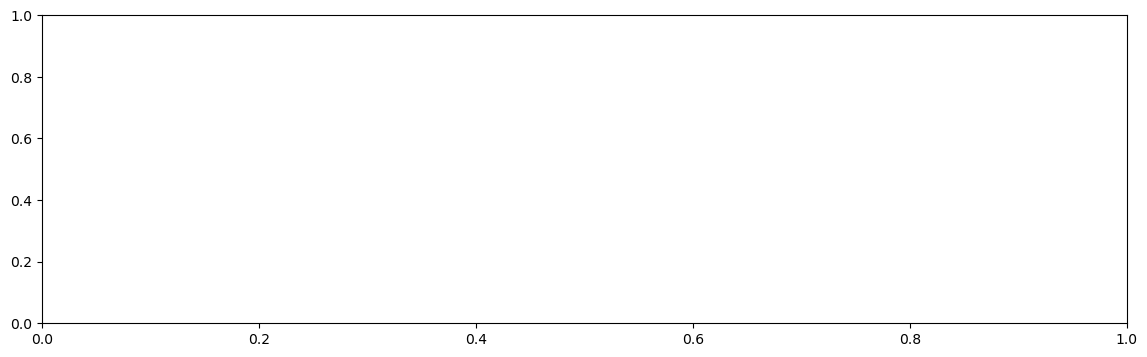

In [39]:
fig, ax = plt.subplots(1, figsize=(14, 4))

sns.scatterplot(x='date', y='total_fine_euro', data=with_controller)
# sns.lineplot(x='date', y='total_fine_euro', data=with_controller)

for _, boi in highbois.iterrows():
    xy = (boi.date, boi.total_fine_euro)
    text = boi.shortname + '\n' + boi.country
    ax.annotate(text=text,
            xy=xy, xycoords='data',
            xytext=(-10, -10), textcoords='offset points',
            ha='right',
            fontsize='medium'
    )

ax.set(title=None, xlabel=None, ylabel ="Total Fine")
ax.set_yscale("log")
ax.yaxis.set_major_formatter('{x:,.0f} €')

## Fine Value Distribution Plots

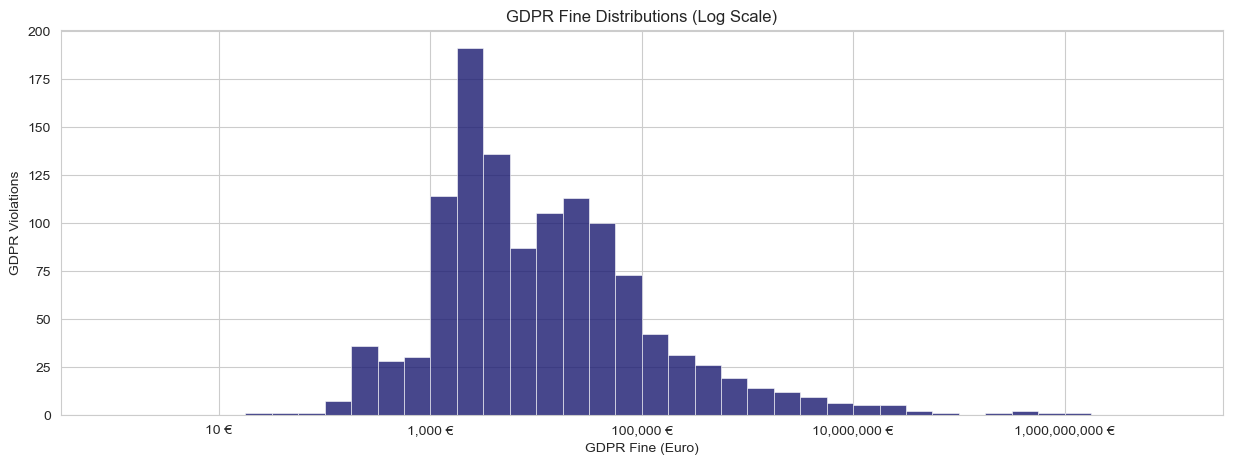

In [232]:
fig, ax = plt.subplots(figsize=(15, 5))

ax = sns.histplot(
    with_controller,
    x="total_fine_euro",
    edgecolor="white",
    linewidth=.5,
    facecolor="midnightblue",
    log_scale=True,
    binrange=(0, 10)
)


for bar in ax.patches:
    bar.set_alpha(0.8) 

ax.set(xlabel="GDPR Fine (Euro)", ylabel="GDPR Violations", title="GDPR Fine Distributions (Log Scale)")
ax.xaxis.set_major_formatter('{x:,.0f} €');

Text(0.5, 0, '')

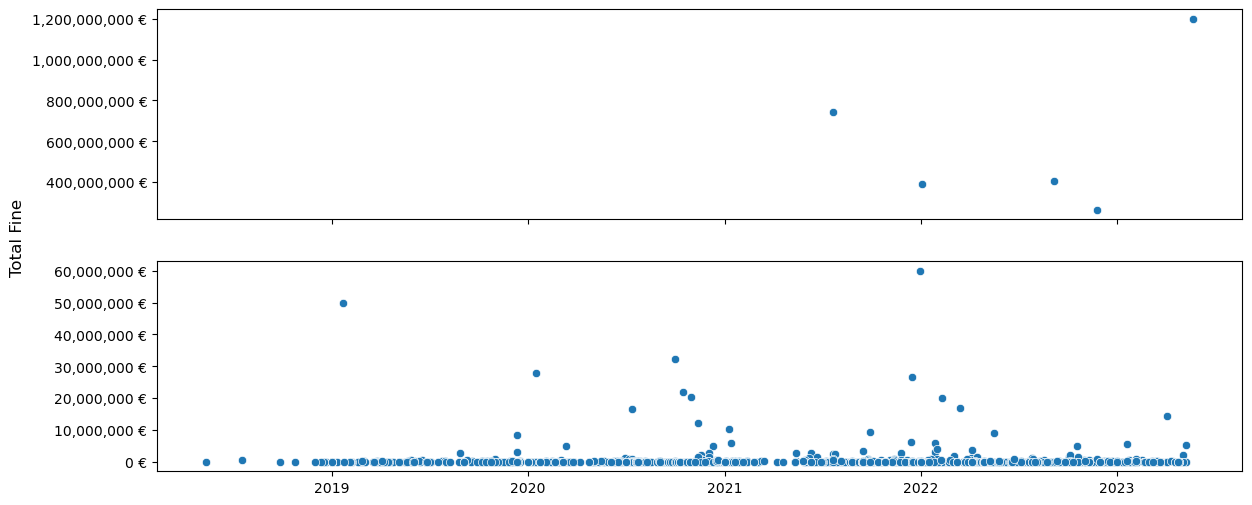

In [124]:
fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True, sharey=False)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro > 2e8'),
    ax=ax[0]
)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro <= 2e8'),
    ax=ax[1]
)

for axis in ax:
    axis.yaxis.set_major_formatter('{x:,.0f} €')
    axis.set_ylabel(None)
fig.supylabel('Total Fine')
plt.xlabel(None)

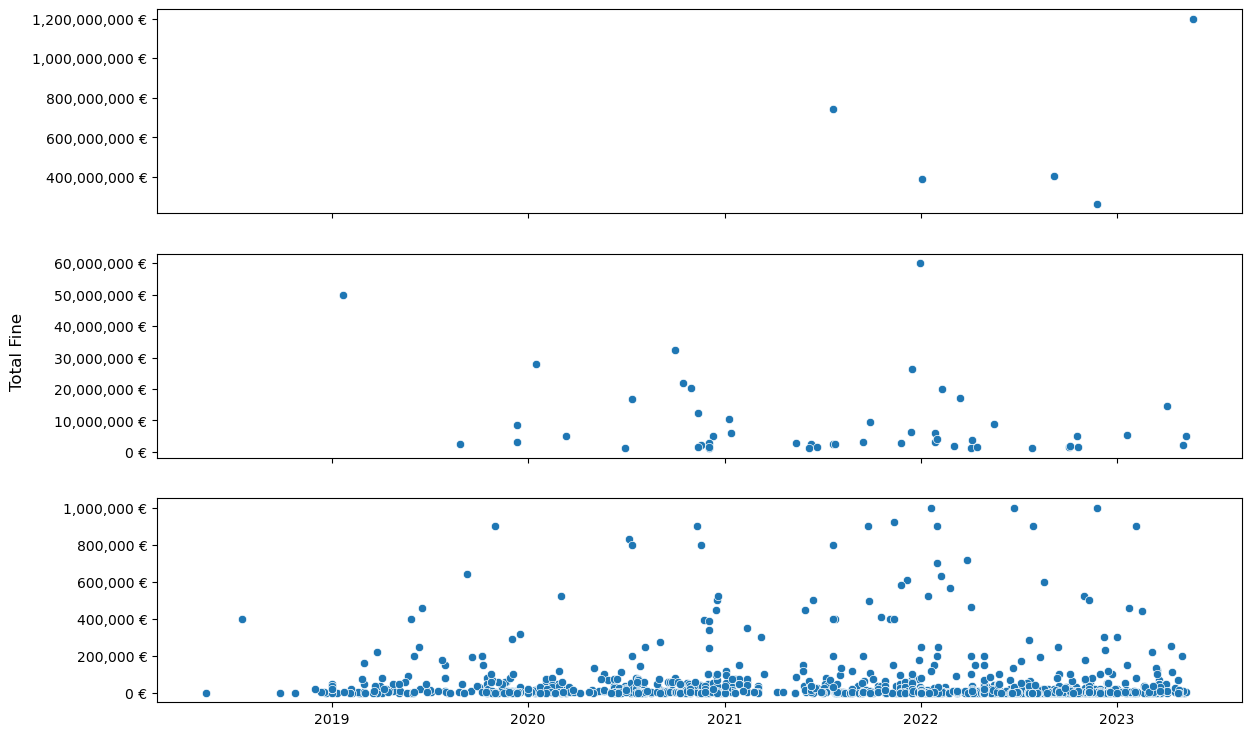

In [126]:
fig, ax = plt.subplots(3, figsize=(14, 9), sharex=True, sharey=False)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro > 2e8'),
    ax=ax[0]
)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('1e6 < total_fine_euro <= 2e8'),
    ax=ax[1]
)

sns.scatterplot(
    x='date', y='total_fine_euro',
    data=with_controller.query('total_fine_euro <= 1e6'),
    ax=ax[2]
)

for axis in ax:
    axis.yaxis.set_major_formatter('{x:,.0f} €')
    axis.set_ylabel(None)
    
fig.supylabel('Total Fine')
plt.xlabel(None);

## Individual Controllers

In [53]:
def strfind(series, term):
    "shorthand"
    return series.str.contains(term, case=False)

(
    with_controller
    .query('total_fine_euro > 1e6')
    .sort_values('date')
    .assign(
        shortname = lambda x: np.select(
            [strfind(x.controller, "Facebook"), strfind(x.controller, "Meta"), strfind(x.controller, "Amazon"), strfind(x.controller, "Google"),
             strfind(x.controller, "Microsoft"), strfind(x.controller, "Vodafone"), strfind(x.controller, "WhatsApp"),
             strfind(x.controller, "Clearview")],
            ["Facebook/Meta", "Facebook/Meta", "Amazon", "Google", "Microsoft", "Vodafone", "WhatsApp", "Clearview AI"],
            x.controller
        )
    )
    .groupby('shortname')
    .total_fine_euro
    .sum()
    .reset_index()
    .sort_values('total_fine_euro', ascending=False)
)


,shortname,total_fine_euro
23,Facebook/Meta,2337000000
3,Amazon,746000000
25,Google,55000000
12,Clearview AI,34200000
27,H&M Hennes & Mauritz Online Shop A.B. & Co. KG,32258708
37,TIM - Telecom Provider,27800000
21,Enel Energia S.p.A.,26500000
8,British Airways,22046000
30,"Marriott International, Inc",20450000
43,Wind Tre S.p.A.,16700000


In [158]:
top_25_fined_controllers = (
    fines_long
    .groupby('controller')
    .agg({'total_fine_euro':['sum', 'count', 'mean']})
    .droplevel(0, axis='columns')
    .reset_index()
    .sort_values('sum', ascending=False)
    .head(25)
)

## Single Violation Exploration

In [84]:
single_violations = (
    with_controller
    .assign(
        n_articles_violated = lambda x: x.loc[:, x.columns.str.startswith('article')].sum(axis='columns')
    )
    .query('n_articles_violated == 1')
    .melt(
        id_vars=['id', 'date', 'year', 'country', 'total_fine_euro', 'controller', 'n_articles_violated'],
        value_vars = with_controller.columns[with_controller.columns.str.startswith('article')].tolist(),
        var_name='article_violated',
        value_name='violated'
    )
    .loc[lambda x: x.violated == 1, ['id', 'date', 'year', 'country', 'total_fine_euro', 'article_violated']]
)

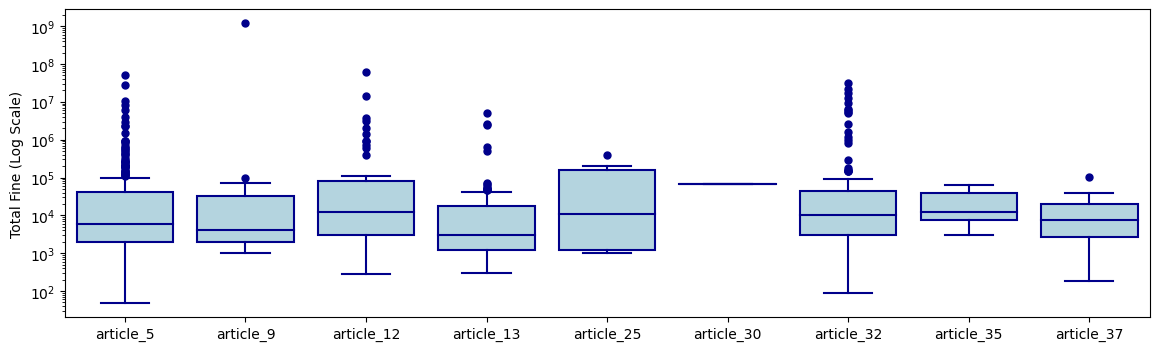

In [128]:
fig, ax = plt.subplots(1, figsize=(14,4))

sns.boxplot(
    y='total_fine_euro',
    x='article_violated',
    data=single_violations,
    ax=ax, color='lightblue',
    whiskerprops={'color':'darkblue'},
    boxprops={'edgecolor':'darkblue'},
    capprops={'color':'darkblue'},
    medianprops={'color':'darkblue'},
    flierprops={
        "marker": "o",
        "markerfacecolor':'darkblue",
                'markeredgecolor':'darkblue'
    })

ax.set(xlabel=None, ylabel="Total Fine (Log Scale)")
ax.set_yscale("log")

## Modelling

```r
library(tidymodels)

gdpr_rec <- recipe(price ~ ., data = gdpr_violations) %>%
  update_role(id, new_role = "id") %>%
  step_log(price, base = 10, offset = 1, skip = TRUE) %>%
  step_other(country, other = "Other") %>%
  step_dummy(all_nominal()) %>%
  step_zv(all_predictors())

gdpr_prep <- prep(gdpr_rec)

gdpr_prep

```

In [237]:
from sklearn.linear_model import LinearRegression

In [244]:
gdpr_model_data

,id,year,country,total_fine_euro,article_5,article_9,article_12,article_13,article_22,article_25,article_30,article_32,article_35,article_37
0,1,2019,Poland,3.972203,1,0,1,1,0,0,0,0,0,0
1,2,2019,Romania,3.397940,1,0,0,0,0,0,0,0,0,0
2,4,2019,Spain,3.903090,0,0,0,0,0,0,0,1,0,0
3,5,2019,Romania,5.176091,0,0,0,0,0,0,0,1,0,0
4,6,2019,Romania,4.301030,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1694,2022,Cyprus,3.176091,1,1,1,0,0,0,0,0,0,0
1196,1697,2023,France,6.716003,0,0,0,0,0,0,0,1,0,0
1197,1698,2020,Malta,3.301030,1,0,0,0,0,0,0,1,0,0
1198,1699,2020,Malta,3.397940,0,0,0,1,0,0,0,0,0,0


In [252]:
X = gdpr_model_data.drop(columns=["id", "total_fine_euro", "country"])
y = gdpr_model_data.total_fine_euro

In [260]:
model = LinearRegression(fit_intercept=True)
fit = model.fit(X, y)

In [321]:
coefs = pd.DataFrame(
    {"intercept" : fit.intercept_} |dict(zip(fit.feature_names_in_, fit.coef_)), index=pd.RangeIndex(start=0, stop=1)
).transpose().reset_index()

In [365]:
import statsmodels.api as sm

,year,article_5,article_9,article_12,article_13,article_22,article_25,article_30,article_32,article_35,article_37
0,2019,1,0,1,1,0,0,0,0,0,0
1,2019,1,0,0,0,0,0,0,0,0,0
2,2019,0,0,0,0,0,0,0,1,0,0
3,2019,0,0,0,0,0,0,0,1,0,0
4,2019,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1195,2022,1,1,1,0,0,0,0,0,0,0
1196,2023,0,0,0,0,0,0,0,1,0,0
1197,2020,1,0,0,0,0,0,0,1,0,0
1198,2020,0,0,0,1,0,0,0,0,0,0


In [421]:
mod = sm.OLS(y, X.assign(constant=1))
res = mod.fit()

coefs = pd.concat([res.params, res.conf_int()], axis=1)

coefs.columns = ['estimate', 'ci0', 'ci1']

coefs.reset_index(names='coef').query('coef != "constant"')

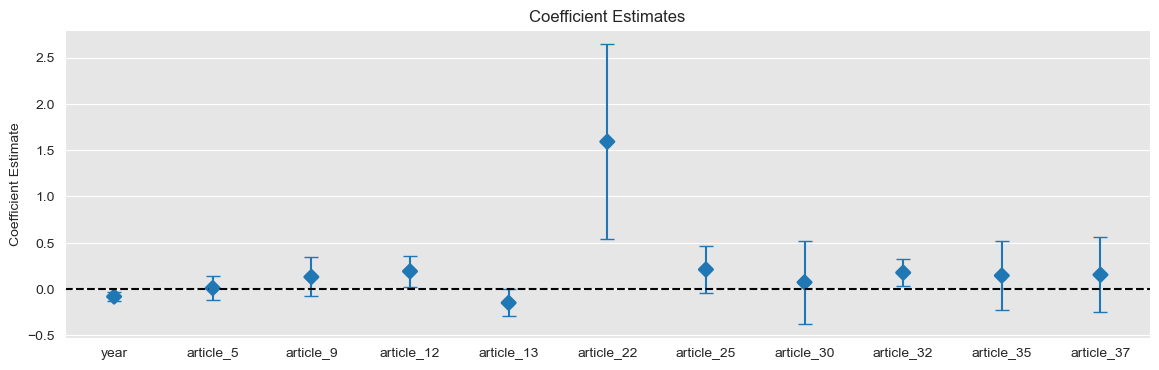

In [472]:
ci_lengths = coefs.ci1 - coefs.estimate

fig, ax = plt.subplots(figsize = (14, 4))

ax = sns.pointplot(
    x='coef', y='estimate',
    data=coefs.reset_index(names='coef').query('coef != "constant"'),
    join=False, markers="D")

ax.errorbar(
    coefs.index[:-1],
    coefs.estimate[:-1],
    yerr=ci_lengths[:-1],
    fmt='o',
    capsize=5
)

ax.axhline(y=0, color="black", linestyle="--")
ax.set(xlabel=None, ylabel="Coefficient Estimate", title="Coefficient Estimates");